In [1]:
import pandas as pd

# Load the dataset
file_path = '/content/train.csv'
data = pd.read_csv(file_path)

# Display basic information about the dataset
data_info = {
    "head": data.head(),
    "info": data.info(),
    "description": data.describe(include="all"),
    "missing_values": data.isnull().sum()
}

data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              37500 non-null  int64  
 1   beer/ABV           37500 non-null  float64
 2   beer/beerId        37500 non-null  int64  
 3   beer/brewerId      37500 non-null  int64  
 4   beer/name          37500 non-null  object 
 5   beer/style         37500 non-null  object 
 6   review/appearance  37500 non-null  float64
 7   review/aroma       37500 non-null  float64
 8   review/overall     37500 non-null  float64
 9   review/palate      37500 non-null  float64
 10  review/taste       37500 non-null  float64
 11  review/text        37490 non-null  object 
 12  review/timeStruct  37500 non-null  object 
 13  review/timeUnix    37500 non-null  int64  
 14  user/ageInSeconds  7856 non-null   float64
 15  user/birthdayRaw   7856 non-null   object 
 16  user/birthdayUnix  785

{'head':    index  beer/ABV  beer/beerId  beer/brewerId                  beer/name  \
 0  40163       5.0        46634          14338                   Chiostro   
 1   8135      11.0         3003            395   Bearded Pat's Barleywine   
 2  10529       4.7          961            365       Naughty Nellie's Ale   
 3  44610       4.4          429              1            Pilsner Urquell   
 4  37062       4.4         4904           1417  Black Sheep Ale (Special)   
 
                 beer/style  review/appearance  review/aroma  review/overall  \
 0     Herbed / Spiced Beer                4.0           4.0             4.0   
 1      American Barleywine                4.0           3.5             3.5   
 2  American Pale Ale (APA)                3.5           4.0             3.5   
 3           Czech Pilsener                3.0           3.0             2.5   
 4         English Pale Ale                4.0           3.0             3.0   
 
    review/palate  review/taste  \
 0   

In [2]:
# Step 1: Handle missing values

# Drop rows with missing 'review/text'
data_cleaned = data.fillna({'review/text': 'Unknown'})

# Fill missing 'user/gender' with 'Unknown'
data_cleaned['user/gender'] = data_cleaned['user/gender'].fillna('Unknown')

# Drop columns with excessive missing values
columns_to_drop = ['user/ageInSeconds', 'user/birthdayRaw', 'user/birthdayUnix','review/timeStruct']
data_cleaned = data_cleaned.drop(columns=columns_to_drop, axis=1)

# Recheck missing values after cleaning
missing_values_after_cleaning = data_cleaned.isnull().sum()

missing_values_after_cleaning


,0
index,0
beer/ABV,0
beer/beerId,0
beer/brewerId,0
beer/name,0
beer/style,0
review/appearance,0
review/aroma,0
review/overall,0
review/palate,0


In [3]:
# Fill missing 'user/profileName' with 'Unknown'
data_cleaned['user/profileName'] = data_cleaned['user/profileName'].fillna('Unknown')

# Recheck missing values to confirm all are handled
final_missing_values = data_cleaned.isnull().sum()

final_missing_values


,0
index,0
beer/ABV,0
beer/beerId,0
beer/brewerId,0
beer/name,0
beer/style,0
review/appearance,0
review/aroma,0
review/overall,0
review/palate,0


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Compute mean and standard deviation of ratings
data_cleaned['review/meanRating'] = data_cleaned[
    ['review/appearance', 'review/aroma', 'review/palate', 'review/taste']
].mean(axis=1)
data_cleaned['review/stdRating'] = data_cleaned[
    ['review/appearance', 'review/aroma', 'review/palate', 'review/taste']
].std(axis=1, ddof=0)

# Vectorize the 'review/text' column
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data_cleaned['review/text'])

# Encode 'beer/style' and 'beer/name' as frequency-based categories
style_counts = data_cleaned['beer/style'].value_counts()
name_counts = data_cleaned['beer/name'].value_counts()

data_cleaned['beer/style_encoded'] = data_cleaned['beer/style'].map(style_counts)
data_cleaned['beer/name_encoded'] = data_cleaned['beer/name'].map(name_counts)

# Check the updated data with new features
data_cleaned[['review/meanRating', 'review/stdRating', 'beer/style_encoded', 'beer/name_encoded']].head(), tfidf_matrix.shape


(   review/meanRating  review/stdRating  beer/style_encoded  beer/name_encoded
 0              4.000          0.000000                  62                 17
 1              3.500          0.353553                 634                 61
 2              3.625          0.216506                1711                 78
 3              3.000          0.000000                1131                947
 4              3.250          0.559017                 971                252,
 (37500, 1000))

In [5]:
#TF-IDF matrix to dataframe, merge it in original data and remove unnecessary columns
import pandas as pd

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
data_final = pd.concat([data_cleaned.reset_index(drop=True), tfidf_df], axis=1)
columns_to_drop = ['index', 'review/text', 'beer/name', 'beer/style',]
data_final = data_final.drop(columns=columns_to_drop, axis=1)


In [6]:
#Train and test data split
from sklearn.model_selection import train_test_split

X = data_final.drop('review/overall', axis=1)
y = data_final['review/overall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.preprocessing import LabelEncoder

# Identify columns with object (string) type
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns

# Apply label encoding to all categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data_cleaned[col] = le.fit_transform(data_cleaned[col].astype(str))
    label_encoders[col] = le


In [8]:
# Split the data
X = data_cleaned.drop('review/overall', axis=1)
y = data_cleaned['review/overall']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")


RMSE: 0.4048019721625213
MAE: 0.30739133333333335
R²: 0.6668859935308404


In [9]:
# Evaluates a model's performance using cross-validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Mean R²: {scores.mean()}")


Mean R²: 0.6668957495086836


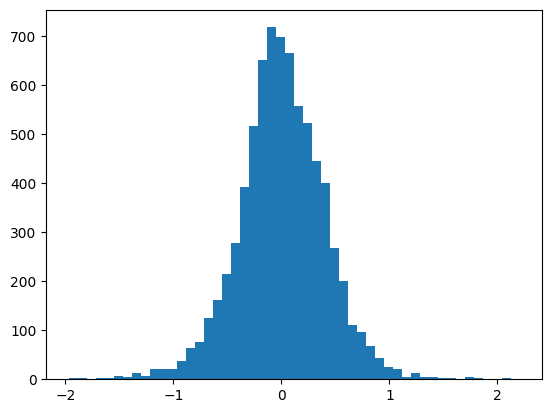

In [10]:
#Differences between actual and predicted values
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.hist(residuals, bins=50)
plt.show()


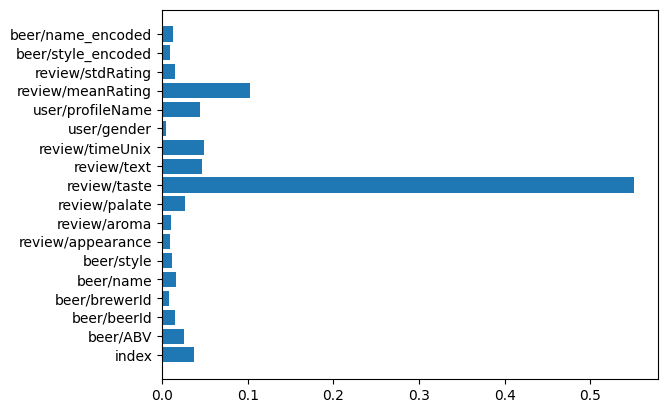

In [11]:
#Feature importance
import matplotlib.pyplot as plt

importance = model.feature_importances_
plt.barh(X_train.columns, importance)
plt.show()
